# Gas turbine combastion chamber model using Cantera constant volume reactor net - nitrogen oxides emission analysis

## Sources:
* Cantera documentation and code examples
<ol>
https://www.cantera.org/docs/sphinx/html/reactors.html<br>
https://www.cantera.org/docs/sphinx/html/cython/examples/reactors_combustor.html#py-example-combustor-py<br>
https://www.cantera.org/docs/sphinx/html/cython/examples/reactors_pfr.html#py-example-pfr-py
</ol>
* CERFACS tutorials
<ol>
http://www.cerfacs.fr/cantera/docs/tutorials/CANTERA_HandsOn.pdf
</ol>
* "Prediction of emissions from combustion systems using 0D and 1D reacting flow models", B.Rosati
<ol>
https://repository.tudelft.nl/islandora/object/uuid:e4123ab3-0d3d-48cc-8b71-ada6badc83e7
</ol>
* "Water Injection in Gas Turbines - Kinetic Modeling with Cantera", S. M. Reiz
<ol>
https://www5.in.tum.de/pub/Reiz2014_BThesis.pdf
</ol>
* "Chemical Reactor Modeling of Oxy - Fuel Combustion Chamber for Semiclosed Combined Cycle", V. P. Timón, G. Corchero, J. L. Montañés
<ol>
https://pubs.acs.org/doi/10.1021/acs.energyfuels.7b01311
</ol>
* Matplotlib library documentation
<ol>
https://matplotlib.org/tutorials/index.html
</ol>
* Numpy library documentation
<ol>
https://docs.scipy.org/doc/numpy/user/quickstart.html
</ol>
* "Tutorial: Generating Reaction Path Diagrams with cantera and Python", Tilman Bremer
<ol>
https://www.tilmanbremer.de/2017/06/tutorial-generating-reaction-path-diagrams-with-cantera-and-python/
</ol>


Importing neccesery libraries

In [1]:
import math
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import os

Model inputs

In [2]:
#thermodynamic parameters

T0_ch4 = 300.0 #methane temperature [K]
p0 = 2500000.0 #inlet preassure[Pa]
T0_air = 700.0
eqv = 0.5 #equivalence ratio
ftar = 1 / 17.2 #fuel to air ratio
X = 0.1 #mixer/DZ air injection ratio

#internal parameters

Kv = 1.0 #valve coefficient
N = 100 #number of steps

#geometrical parameters

Dc = 0.3 #combustor diameter [m]
D = 0.1 #mixing tube diameter [m]
mixer_length = 0.1 #[m]
PZ_length = 0.2 #[m]
SZ_length = 0.5 #[m]
DZ_length = 0.5 #[m]
Lc = mixer_length + PZ_length + SZ_length + DZ_length

mixer_vol = mixer_length * D**2 * math.pi / 4.0
PZ_vol = PZ_length* Dc**2 * math.pi / 4.0
r_vol = (Lc - mixer_length) * Dc**2 * math.pi / 4.0 / N
dz = (SZ_length + DZ_length) / N

#igniter

fwhm = 0.2
amplitude = 1.0
t0 = 0.5
igniter_mdot = lambda t: amplitude * math.exp(-(t-t0)**2 * 4 * math.log(2) / fwhm**2)

Setting up gas reaction mechanisms

In [3]:
air = ct.Solution('air.xml')
gas = ct.Solution('gri30.xml')

Creating data arrays

In [4]:
data1 = np.empty((4,6,11,3))
z1 = [0, mixer_length, mixer_length + PZ_length]

data = np.empty((4,6,11,N))
z = np.arange(N) * dz + (mixer_length + PZ_length)
t_res = np.zeros_like(z)  # residence time in each reactor
u = np.zeros_like(z)
t = np.zeros_like(z)

Simulation loop (I know that putting "everything" in the loop is kind of stupid and very slow but i couldn't find another solution to the problem)

In [5]:
a = 0
b = 0

while eqv <= 1.5:
    
    while X <= 1.0:
        
        
        #setting up reservoirs
        air.TP = T0_air, p0, 
        air_res = ct.Reservoir(air)
        air.TP = 300.0, ct.one_atm
        env = ct.Reservoir(air)

        gas.TPX = T0_ch4, p0, 'CH4:1.0'
        ch4_res = ct.Reservoir(gas)
        gas.TPX = 700.0, p0, 'N2:1.0'
        upstream = ct.Reservoir(gas)
        downstream = ct.Reservoir(gas)
        gas.TPX = 700.0, p0, 'H:1.0'
        igniter = ct.Reservoir(gas)

        
        #setting up reactors
        mixer = ct.IdealGasReactor(gas,energy = 'on')
        mixer.volume = mixer_vol

        PZ = ct.IdealGasReactor(gas, energy = 'on')
        PZ.volume = PZ_vol

        r = ct.IdealGasReactor(gas, energy = 'on')
        r.volume = r_vol
        states = ct.SolutionArray(r.thermo)
        
        
        #setting up flow devices and walls
        r_wall = ct.Wall(r, env, A = PZ_length*D*math.pi, U = 30.0)
        PZ_wall = ct.Wall(PZ, env, A = PZ_length*D*math.pi, U = 30.0)
        
        air_mf1 = X * 100.0 #air mass flow [kg/s]
        air_mfc1 = ct.MassFlowController(air_res, mixer, mdot = air_mf1)
        
        ch4_mf = ftar*eqv*air_mf1
        ch4_mfc = ct.MassFlowController(ch4_res, mixer, mdot = ch4_mf)
        
        mass_flow_rate = air_mf1 + ch4_mf
        r_mfc = ct.MassFlowController(upstream, r, mdot = mass_flow_rate)

        igniter_mfc = ct.MassFlowController(igniter, PZ, mdot = igniter_mdot)

        air_mf2 = (1 - X) * 100.0 #air mass flow to SZ and DZ[kg/s]
        dilution_air_mf = air_mf2 / (SZ_length + DZ_length) / Lc / N
        dilution_air_mfc = ct.MassFlowController(air_res, r, mdot = dilution_air_mf)

        mixer_v = ct.Valve(mixer, PZ, K = Kv)
        PZ_v = ct.Valve(PZ, upstream, K = Kv)
        r_v = ct.Valve(r, downstream, K = Kv)
        
        
        #data acquisition
        data1[0,a,b,0] = mixer.thermo.T
        data1[1,a,b,0] = mixer.thermo.Y[gas.species_index('NO')]
        data1[2,a,b,0] = mixer.thermo.Y[gas.species_index('NO2')]
        data1[3,a,b,0] = mixer.thermo.Y[gas.species_index('N2O')]
        
        #iterating through CTSR net (mixer and primary zone)
        sim = ct.ReactorNet([mixer, PZ])
            
        sim.reinitialize()
        sim.advance_to_steady_state()
        
        #data acquisiton
        data1[0,a,b,1] = mixer.thermo.T
        data1[1,a,b,1] = mixer.thermo.Y[gas.species_index('NO')]
        data1[2,a,b,1] = mixer.thermo.Y[gas.species_index('NO2')]
        data1[3,a,b,1] = mixer.thermo.Y[gas.species_index('N2O')]
        data1[0,a,b,2] = PZ.thermo.T
        data1[1,a,b,2] = PZ.thermo.Y[gas.species_index('NO')]
        data1[2,a,b,2] = PZ.thermo.Y[gas.species_index('NO2')]
        data1[3,a,b,2] = PZ.thermo.Y[gas.species_index('N2O')]
        
        gas.TDY = PZ.thermo.TDY
        upstream.syncState()

        
        #iterating through PFR net (secondary and dilution zone)
        sim2 = ct.ReactorNet([r])

        for n in range(N):

            if z[n] >= mixer_length + PZ_length and z[n]< Lc- DZ_length:
                dilution_air_mfc.set_mass_flow_rate(dilution_air_mf)
                mass_flow_rate += dilution_air_mf
                sim2.reinitialize()
                sim2.advance_to_steady_state()
                u[n] = mass_flow_rate / (Dc**2 * math.pi / 4.0) / r.thermo.density #flow velocity in this reactor
                t_res[n] = r.mass / mass_flow_rate  # residence time in this reactor
                t[n] = np.sum(t_res) #time
                gas.TDY = r.thermo.TDY
                upstream.syncState()
                
                #data acquisition
                data[0,a,b,n] = r.thermo.T
                data[1,a,b,n] = r.thermo.Y[gas.species_index('NO')]
                data[2,a,b,n] = r.thermo.Y[gas.species_index('NO2')]
                data[3,a,b,n] = r.thermo.Y[gas.species_index('N2O')]

            elif z[n] >= Lc - DZ_length and z[n]< Lc:
                dilution_air_mfc.set_mass_flow_rate(dilution_air_mf)
                mass_flow_rate += dilution_air_mf
                sim2.reinitialize()
                sim2.advance_to_steady_state()
                u[n] = mass_flow_rate / (Dc**2 * math.pi / 4.0) / r.thermo.density #flow velocity in this reactor
                t_res[n] = r.mass / mass_flow_rate  # residence time in this reactor
                t[n] = np.sum(t_res) # times
                gas.TDY = r.thermo.TDY
                upstream.syncState()
                
                #data acquisition
                data[0,a,b,n] = r.thermo.T
                data[1,a,b,n] = r.thermo.Y[gas.species_index('NO')]
                data[2,a,b,n] = r.thermo.Y[gas.species_index('NO2')]
                data[3,a,b,n] = r.thermo.Y[gas.species_index('N2O')]

        
        X += 0.1
        b += 1

    eqv += 0.2
    a += 1
    b = 0
    X = 0.1

Plotting (example plots for secondary and dilution zone)

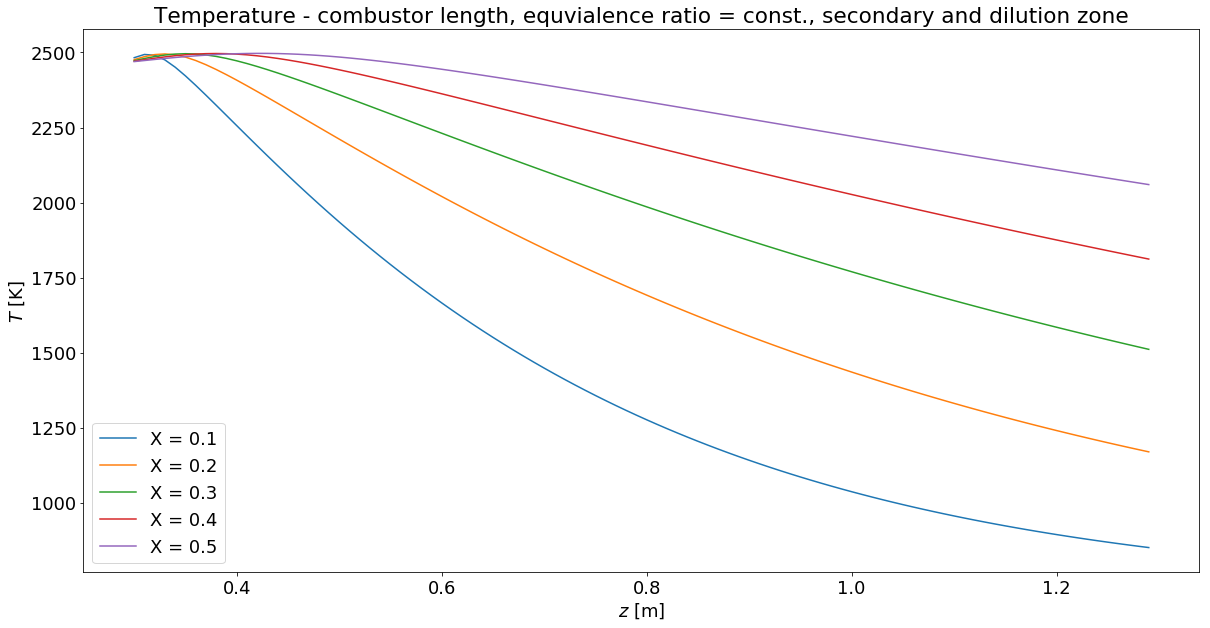

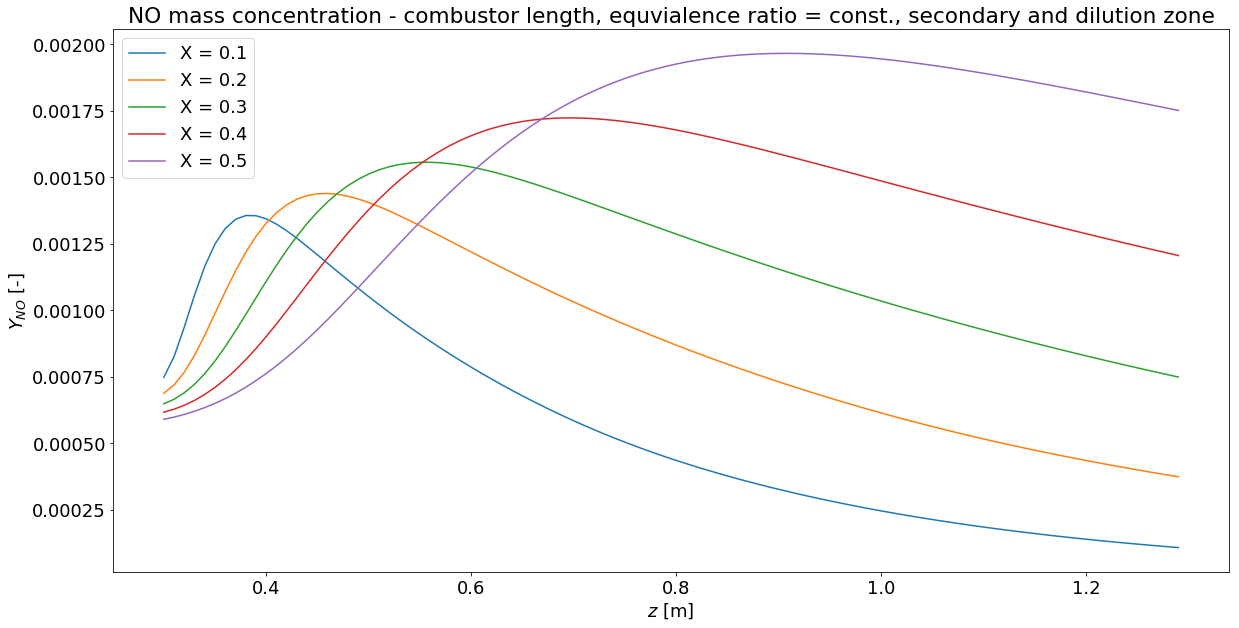

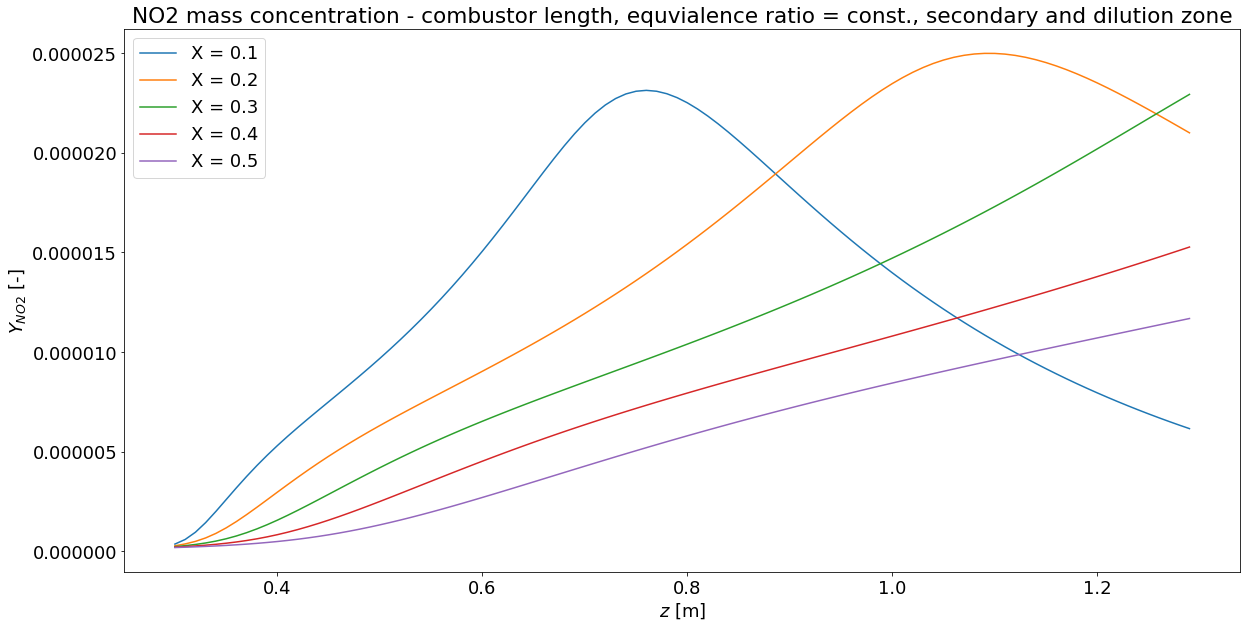

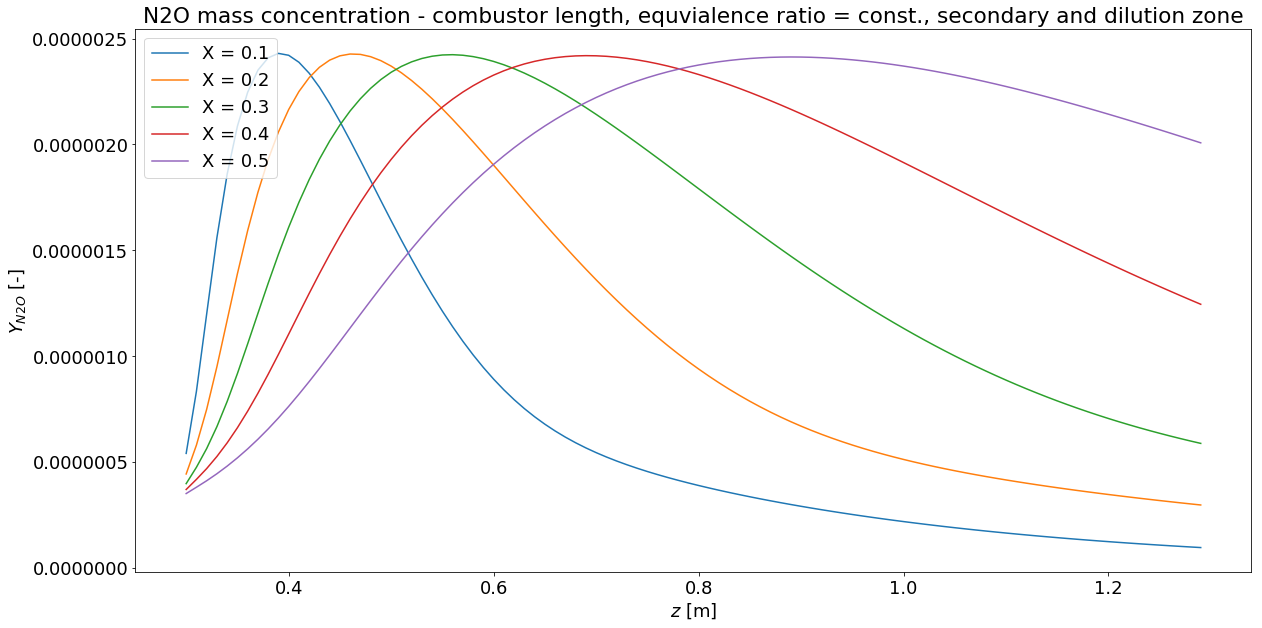

In [12]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

plt.figure(figsize=(20,10))
for i in range(5):
    plt.plot(z, data[0,3,i+1,:], label = 'X = %.1f' % (0.1*(i+1)))
plt.xlabel('$z$ [m]')
plt.ylabel('$T$ [K]')
plt.title("Temperature - combustor length, equvialence ratio = const., secondary and dilution zone")
plt.legend()
plt.show()
#plt.savefig('T_z_Xvar.png')

plt.figure(figsize=(20,10))
for i in range(5):
    plt.plot(z, data[1,3,i+1,:], label = 'X = %.1f' % (0.1*(i+1)))
plt.xlabel('$z$ [m]')
plt.ylabel('$Y_{NO}$ [-]')
plt.title("NO mass concentration - combustor length, equvialence ratio = const., secondary and dilution zone")
plt.legend()
plt.show()
#plt.savefig('YNO_z_Xvar.png')

plt.figure(figsize=(20,10))
for i in range(5):
    plt.plot(z, data[2,3,i+1,:], label = 'X = %.1f' % (0.1*(i+1)))
plt.xlabel('$z$ [m]')
plt.ylabel('$Y_{NO2}$ [-]')
plt.title("NO2 mass concentration - combustor length, equvialence ratio = const., secondary and dilution zone")
plt.legend()
plt.show()
#plt.savefig('YNO2_z_Xvar.png')

plt.figure(figsize=(20,10))
for i in range(5):
    plt.plot(z, data[3,3,i+1,:], label = 'X = %.1f' % (0.1*(i+1)))
plt.xlabel('$z$ [m]')
plt.ylabel('$Y_{N2O}$ [-]')
plt.title("N2O mass concentration - combustor length, equvialence ratio = const., secondary and dilution zone")
plt.legend()
plt.show()
#plt.savefig('YN2O_z_Xvar.png')

Drawing nitrogen reaction path diagram (example)

In [7]:
diagram = ct.ReactionPathDiagram(gas, 'N')
 
diagram.show_details = False
diagram.font='CMU Serif Roman'
diagram.threshold=0.01
diagram.dot_options='node[fontsize=20,shape="box"]'
diagram.title = 'Reaction path diagram following {0}'.format('N')
 
dot_file = 'ReactionPathDiagram.dot'
img_file = 'ReactionPathDiagram.png'
 
#diagram.write_dot(dot_file)
#os.system('dot {0} -Gdpi=300 -Tpng -o{1}'.format(dot_file, img_file))